# Dashboard Staging

In [1]:
flex_title = "CineScope Movie Recommender"
flex_orientation = "rows"
flex_subtitle = "A recommender project demoed with jupyter-flex"
flex_include_source = True
flex_source_link = "https://github.com/CBanalyst10/CineScope/blob/main/a11_CineScope_Model.ipynb"

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('ALS_recommender') \
    .getOrCreate()


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

import plotly.express as px

In [3]:
#Settings
# Set ipython's max row display
pd.set_option('display.max_row', 50)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# parameters block
plt.style.use("ggplot")
%matplotlib inline


plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black",
                    'xtick.color' : "black",
                    'ytick.color' : "black"})

In [4]:
import tmdbsimple as tds
import pdb

keys = pd.read_csv('keys.txt')
keys['kDb3'][0]
tds.API_KEY = keys['kDb3'][0]

In [5]:
#import os

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip
)

#from IPython.display import display
import ipywidgets as widgets
#from IPython.html.widgets import interactive # deprecated, moved to ipywidgets below
from ipywidgets import HBox, VBox, IntSlider, Play, jslink, interactive


import plotly.graph_objects as go

import tabloo

#from tkinter import *
#import tkinter as tk
#import pandastable
#from pandastable import Table, TableModel

In [6]:
merged_movie_r_df_num = pd.read_csv('data/merged_movies_and_ratings_reduced.csv')
merged_movie_r_df_num.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
def df_to_pivot(df, user, item, value, mode='p'):
    if mode=='p':      
        return df[[user, item, value]].pivot(index=user, columns=item, values=value)
    elif mode=='pt':
        return pd.pivot_table(df, index=user, columns=item, values=value)
    else:
        print('Please specify a mode!')

In [8]:
#print('Parsing Movies')
ml_m_df = pd.read_csv("ml-25m/movies.csv")
#print(ml_m_df.info())
#print('\n')
ml_m_df.drop(columns=['genres'], inplace=True)

In [9]:
merged_movie_r_df_num['startYear'] = merged_movie_r_df_num['startYear'].astype('uint32')
merged_movie_r_df_num['timeyear'] = merged_movie_r_df_num['timeyear'].astype('uint32')
dfui8c = ['gnr_Action', 'gnr_Adult', 'gnr_Adventure', 'gnr_Animation', 'gnr_Biography', 'gnr_Comedy',
          'gnr_Crime', 'gnr_Documentary', 'gnr_Drama', 'gnr_Family', 'gnr_Fantasy', 'gnr_Film-Noir',
          'gnr_History', 'gnr_Horror', 'gnr_Music', 'gnr_Mystery', 'gnr_Romance', 'gnr_Sci-Fi', 'gnr_Sport',
          'gnr_Thriller', 'gnr_War', 'gnr_Western', 'original_language_en', 'original_language_hi', 'original_language_it', 'original_language_ja',
          'original_language_sv']
for ui8col in dfui8c:
    merged_movie_r_df_num[ui8col] = merged_movie_r_df_num[ui8col].astype('uint8')

In [10]:
def money_impute(mudf):
    """
    Input: merged dataframe of user ratings and their corresponding movie
    Output: this dataframe but with imputed budget and revenue, based on the median
    """
    mudf = mudf.copy()
    bm = mudf['budget'].median()
    rm = mudf['revenue'].median()
    
    mudf['budget'] = mudf['budget'].apply(lambda x: x if x>0 else bm)
    mudf['revenue'] = mudf['revenue'].apply(lambda x: x if x>0 else rm)
    
    # Entries were rev is 0 and budget less than rm, assign rm.
    #mudf['revenue'] = np.where(((mudf.revenue <= 0) & (mudf.budget <= rm), rm, mudf.revenue))
                               
    # If the budget was greater than rm, assign the budget for what 0 remain.
    #mudf['revenue'] = np.where(((mudf.revenue <= 0) & (mudf.budget > rm), mudf.budget, mudf.revenue))

    return mudf

In [11]:
merged_movie_r_df_imp = money_impute(merged_movie_r_df_num)

In [12]:
def merged_split_user_item(mudf):
    """
    Input: merged dataframe of user ratings and their corresponding movie
    Output: two split dataframes containing only users and only movies respectively
    """
    udf = mudf[['userId', 'movieId', 'rating', 'timeyear']]
    mdf = mudf.drop(columns=['userId', 'rating', 'timeyear']).drop_duplicates(subset='movieId')
    
    return udf.sort_values('userId').reset_index(drop=True), mdf.sort_values('movieId').reset_index(drop=True)

In [13]:
#creating separate dataframes for vectorization
user_r_df, movie_df = merged_split_user_item(merged_movie_r_df_imp)

In [14]:
movie_df.drop(columns = ['vote_average', 'vote_count'], inplace=True) # Less popular platform has less useful content.

In [15]:
movie_df['budget'] = movie_df['budget'].astype(int)
movie_df['revenue'] = movie_df['revenue'].astype(int)

In [16]:
def movie_split_away_context(mdf, si=True):
    """
    Input: movie dataframe of all movie data
    Output: two split dataframes, one containing only fields common in the user vector, the other containing only
      context data
    Purpose: creating split data to test use of LightFM
    """
    mdf = mdf.copy()
    ctdf = mdf[['movieId','budget', 'revenue', 'popularity', 'startYear', 'runtimeMinutes',
                'averageRating', 'numVotes']]
    cmdf = mdf.drop(columns=['budget', 'revenue', 'popularity', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes'])
    ctdf.sort_values('movieId')
    cmdf.sort_values('movieId')
    
    if si==True:
        ctdf.set_index('movieId')
        cmdf.set_index('movieId')
    
    return cmdf, ctdf

In [17]:
movie_vector_df, movie_context_df = movie_split_away_context(movie_df)

In [18]:
def expandvectormax(df, s=100, si=None, ei=27, zb=None):
    """
    Inputs:
    df: the movie vector dataframe
    s: scalar to multiply the vector
    """
    df = df.copy()
    
    if si:
        df.iloc[:,si:ei] = df.iloc[:,si:ei].mul(s)
        if zb:
            df.iloc[:,si:ei] = df.iloc[:,si:ei].where(df.iloc[:,si:ei]>0)
    else:
        df.iloc[:,:ei] = df.iloc[:,:ei].mul(s)
        if zb:
            df.iloc[:,:ei] = df.iloc[:,:ei].where(df.iloc[:,:ei]>0, zb)
    return df

In [19]:
movie_vector_dfe = expandvectormax(movie_vector_df, s=100, zb=1)
movie_vector_dfe.set_index('movieId', inplace=True)

In [20]:
#ufv = user vector fields, the fields used in a user vector. This is for the overall unreduced dataset.
uvf = list(movie_vector_dfe.iloc[:,:27].columns)

In [21]:
# user_r_df['userId'].max() # Let all new user profiles begin past this maximum
# Current max: 162541

In [22]:
def set_user_weights(uid, uvfi=uvf, s=100, ud=None, sdf=None, m='set'):
    """
    NOTE: Needs more work.
    Function description: Takes in a dictionary of initial user data. Returns...
      a vector of the user's preferences
    
    uid = user ID. Establishes user if nonexistent, overwrites data if the user does exist.
    ufv = user vector fields. Often not changed, made modifiable for different input data.
    ud = update dictionary. TO BE IMPLEMENTED!
    sdf = source dataframe. If None, builds a new dataframe. If a dataframe is passed in, the new user data
      is added to it.
    m = mode. 'set' creates or replaces data at a specific user index. TO BE EXPANDED!
    """
    nudl = None
    complete = False
    
    
    while complete == False:
        inps = input("Would you like to set your genre preferences? Yes/No: ")
        if (complete == False) and ((str(inps).lower() == "yes") or (str(inps).lower() == "y")):
            nudl = list()
            for field in uvfi:
                inpd = input(f"Enter your preference level for {field} from 0 to {s}. Press Enter/Return for neutral preference.")
                if int(inpd) > s:
                    inpd = s
                elif int(inpd) <0:
                    inpd = 0
                nudl.append(int(inpd))
            complete = True
        elif (complete == False) and ((str(inps).lower() == "no") or (str(inps).lower() == "n")):
            nudl = list()
            for field in uvfi:
                nudl.append(math.floor(s/2))
            complete = True
        else:
            nudl = list()
            print('Please enter Yes or No. (y/n)')
    ndf = pd.DataFrame(columns=uvfi)
    if sdf:
        ndf = sdf.copy()
    ndf.loc[uid] = nudl #If the id is new, adds a new row. If the id exists it replaces this row.
    return ndf

In [23]:
def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""

    return round(number * 2) / 2

In [24]:
merged_movie_r_df_reduced = merged_movie_r_df_imp.drop(columns=
                                                       ['revenue', 'gnr_Crime', 'gnr_Adult', 
                                                        'original_language_sv', 'original_language_sv',
                                                        'gnr_History', 'gnr_Family', 'gnr_Animation',
                                                        'gnr_Biography', 'gnr_Crime', 'gnr_Fantasy',
                                                        'gnr_Film-Noir', 'gnr_Music', 'gnr_Mystery',
                                                        'gnr_Romance', 'gnr_Sport', 'gnr_War', 'gnr_Western'])

In [25]:
merged_movie_r_df_sample = merged_movie_r_df_reduced.sample(n=1000000, random_state=np.random.RandomState())

# MetaUser generation and selection
## Generation
This function could be used to thwart the cold-start problem and search against recommendations. The function takes in a particular movie and rating, then pulls in the average of all movie attributes of all movies such users watch. This means that when a user gives a single movie a rating, value weights for all attributes a movie can have is applied to that user. Recommendation discovery then based off this information.
## Selection
If the user only selects a particular movie without giving a rating, assume they want to give it a high rating. Return results for the highest metauser score found for that movie. As the user selects more movies, the metauser results are then averaged together further into the unique blend of values that define this user.

In [26]:
def gen_user_weights(fr_df, dfsi=8, dfei=38, mltc = 'rating', dc=['movieId'], sort_ind = 'userId', mexp=2, dexp=2):
    """
    Takes in a full ratings dataframe containing all relevant movie, user and rating data.
    
    Returns a dataframe with summary users (metausers), groups by movie and rating bucket.
    
    Operations: Generate a metauser profile based on a rating given to a particular movie.
    
    Inputs:
    fr_df = full ratings dataframe (pandas dataframe): a frame containing all user ratings
      and their corresponding movie data.
      
    umr_dct = user's movie ratings dictionary: a dictionary containing all of the user's identified movies
      and their given rating. If a movie is given no rating, assume 5. If no ratings of 5 are found for
      a given movie, seek the next lowest score.
      
    Outputs:
    mud_df = metauser data (pandas dataframe): returns a pandas dataframe of all rating buckets per movie
      and their averaged field values, a form of meta user.
    """
    fr_df = fr_df.copy()
    dfpc = list(fr_df.iloc[:,dfsi:dfei].drop(columns=dc).sort_values(sort_ind).set_index(sort_ind).columns)
    
    # print(f'Columns to parse: {dfpc}\n')
    
    agd = {mltc: 'sum'}
    agdc = [mltc]
    for genre in dfpc:
        agd[mltc + '_' + genre] = 'sum'
        fr_df[mltc + '_' + genre] = fr_df[genre] * fr_df[mltc]**mexp
        agdc.append(mltc + '_' + genre)
        
    # print(f'Aggregate column operations: {agd}\n')
    # print(f'Columns to remove at end: {agdc}\n')
        
    df_agg = fr_df.groupby([sort_ind]).agg(agd)
        
    for genre in dfpc:
        df_agg['wgtd_' + genre] = (df_agg[mltc + '_' + genre] / df_agg[mltc]**dexp)
        # The above assignment could be rounded but I don't think this is needed.
        
    return df_agg.drop(columns=agdc)

In [27]:
uwdf = gen_user_weights(merged_movie_r_df_sample, mexp=2, dexp=2)
# uwdf

In [28]:
merged_movie_r_df_imp_e = expandvectormax(merged_movie_r_df_imp, s=100, si=9, ei=36)

In [29]:
merged_movie_r_df_spl_e = expandvectormax(merged_movie_r_df_sample, s=100, si=8, ei=20, zb=1)
merged_movie_r_df_spl_e = merged_movie_r_df_spl_e.where(pd.notnull(merged_movie_r_df_spl_e), 1)

In [30]:
merged_movie_r_df_imp_r = merged_movie_r_df_imp_e.drop(columns=[
       'gnr_Action', 'gnr_Adult', 'gnr_Adventure', 'gnr_Animation',
       'gnr_Biography', 'gnr_Comedy', 'gnr_Crime', 'gnr_Documentary',
       'gnr_Drama', 'gnr_Family', 'gnr_Fantasy', 'gnr_Film-Noir',
       'gnr_History', 'gnr_Horror', 'gnr_Music', 'gnr_Mystery', 'gnr_Romance',
       'gnr_Sci-Fi', 'gnr_Sport', 'gnr_Thriller', 'gnr_War', 'gnr_Western',
       'original_language_en', 'original_language_hi', 'original_language_it',
       'original_language_ja', 'original_language_sv'])

# Spark content below

In [31]:
rec_sdf_r = spark.createDataFrame(merged_movie_r_df_sample) # largest tested load sample: 1 million

In [32]:
print('Number of unique users: {}'.format(rec_sdf_r.select('userId').distinct().count()))
print('Number of unique movies: {}'.format(rec_sdf_r.select('movieId').distinct().count()))
print('Number of rating: {}'.format(rec_sdf_r.count()))
# The density of this sample matrix is 
rec_sdf_r.count()/(rec_sdf_r.select('userId').distinct().count()*rec_sdf_r.select('movieId').distinct().count())

Number of unique users: 142350
Number of unique movies: 18344
Number of rating: 1000000


0.00038295565480744913

In [33]:
#Making split for sample
train, test = rec_sdf_r.randomSplit([0.8, 0.2], seed=10)
train.count(), test.count()

(799925, 200075)

Max Ratings: 724
Min Ratings: 1


<AxesSubplot:>

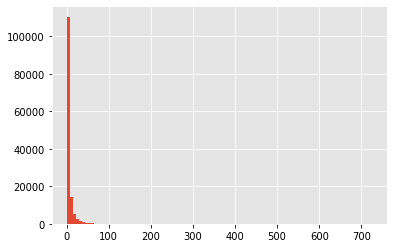

In [34]:
user_count = train.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 2695
Min Ratings: 1


<AxesSubplot:>

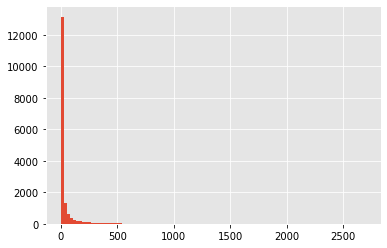

In [35]:
movie_count = train.groupBy('movieId').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 179
Min Ratings: 1


<AxesSubplot:>

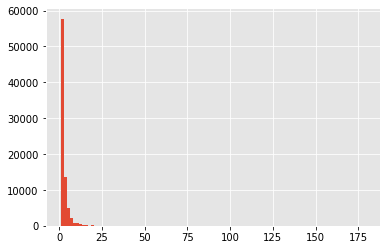

In [36]:
user_count = test.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

In [37]:
als_model = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender = als_model.fit(train)

# This kind sample will need to be recreated from a class object that holds user parameters.
The ideal goal is to be able to catalogue distinct user profiles that each hold their information. The goal is to write their profiles to file/database to be able to call them as required.

In [38]:
data = [(51787, 524)]
columns = ('userId', 'movieId')
one_row_spark_df = spark.createDataFrame(data, columns)
one_row_spark_df.show()

+------+-------+
|userId|movieId|
+------+-------+
| 51787|    524|
+------+-------+



In [39]:
user_factor_df = recommender.userFactors.filter('id = 51787')
item_factor_df = recommender.itemFactors.filter('id = 524')

In [40]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [41]:
np.dot(user_factors, item_factors)

3.948134817400506

In [42]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
| 51787|    524|  3.948135|
+------+-------+----------+



In [43]:
# Get the top movies for a user 1

recommender.recommendForUserSubset(one_row_spark_df, 10).show(10, False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                          |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|51787 |[{141359, 6.5876117}, {82227, 6.449973}, {146210, 6.3654866}, {140759, 6.248904}, {165239, 6.048399}, {106173, 5.8658795}, {111757, 5.8658795}, {112988, 5.860007}, {2308, 5.8493047}, {3533, 5.7280893}]|
+------+----------------------------------------------------------------------------------------------------------------------------------------------------

# Recommender output summary and next steps
The recommender can target a single user within the dataframe and deliver a recommendation for them. Try to find a way to recommend to a user who is not within the dataset.

Possible solution: https://datascience.stackexchange.com/questions/14744/spark-als-recommending-for-new-users
Fold-In explanation:


Lots of questions here. First, for a truly new user with no data, there is no way to use a recommender model. If you have literally no information on the user, the only thing you can do is provide some default recommendations.

Of course, once you have any data, and you can rebuild the model to incorporate the user, you can make recommendations. You can do that in Spark but you already know that. This will take too long if you need to add information about new users at runtime. The technique you want is called "fold-in", used to figure out what the new user vector is (approximately) given the items the user interacts with. It's just some linear algebra and does follow from the equation you give.



In [44]:
predictions = recommender.transform(test)

In [45]:
# add the implicit rating column

train = train.withColumn("imp_rating", lit(1))
train.show(5)

+------+----------+------------+----------+---------+--------------+-------------+--------+----------+-------------+----------+---------------+---------+----------+----------+------------+--------------------+--------------------+--------------------+--------------------+------+-------+------+--------+----------+
|budget|popularity|vote_average|vote_count|startYear|runtimeMinutes|averageRating|numVotes|gnr_Action|gnr_Adventure|gnr_Comedy|gnr_Documentary|gnr_Drama|gnr_Horror|gnr_Sci-Fi|gnr_Thriller|original_language_en|original_language_hi|original_language_it|original_language_ja|userId|movieId|rating|timeyear|imp_rating|
+------+----------+------------+----------+---------+--------------+-------------+--------+----------+-------------+----------+---------------+---------+----------+----------+------------+--------------------+--------------------+--------------------+--------------------+------+-------+------+--------+----------+
|   1.0|      2.88|        3.75|        14|     1998|  

In [46]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='imp_rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [47]:
# Looking at the recommendations for user 1 to compare to what the explicit gave back 
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

[Row(userId=51787, recommendations=[Row(movieId=1, rating=0.40151000022888184), Row(movieId=589, rating=0.39860299229621887), Row(movieId=110, rating=0.3970448076725006), Row(movieId=380, rating=0.2654477059841156), Row(movieId=3578, rating=0.22490471601486206), Row(movieId=344, rating=0.053770437836647034), Row(movieId=231, rating=0.0458681620657444), Row(movieId=364, rating=0.037108924239873886), Row(movieId=111, rating=0.03634877875447273), Row(movieId=597, rating=0.03208521753549576)])]

In [48]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [49]:
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

[Row(userId=51787, recommendations=[Row(movieId=589, rating=0.5122790336608887), Row(movieId=110, rating=0.5118929743766785), Row(movieId=1, rating=0.5084799528121948), Row(movieId=3578, rating=0.4259767234325409), Row(movieId=1089, rating=0.3777698576450348), Row(movieId=380, rating=0.377691388130188), Row(movieId=1097, rating=0.2937101423740387), Row(movieId=111, rating=0.2923208773136139), Row(movieId=1682, rating=0.27422600984573364), Row(movieId=1246, rating=0.22245405614376068)])]

In [50]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [51]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [52]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [53]:
predictions_df.head()

,budget,popularity,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adventure,gnr_Comedy,gnr_Documentary,gnr_Drama,gnr_Horror,gnr_Sci-Fi,gnr_Thriller,original_language_en,original_language_hi,original_language_it,original_language_ja,userId,movieId,rating,timeyear,prediction,squared_error
0,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,132310,148,3.0,1996,2.068438,0.867807
1,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,48928,148,2.0,2000,1.424011,0.331764
2,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,107249,148,4.0,2001,2.133359,3.484349
3,25000000.0,10.682,3.55,697,1994,111.0,3.6,77498,0,0,1,0,1,0,0,0,1,0,0,0,62935,471,4.0,2004,3.480148,0.270246
4,25000000.0,10.682,3.55,697,1994,111.0,3.6,77498,0,0,1,0,1,0,0,0,1,0,0,0,112101,471,2.0,1999,3.414843,2.001780


In [54]:
predictions_df.describe()

,budget,popularity,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adventure,gnr_Comedy,gnr_Documentary,gnr_Drama,gnr_Horror,gnr_Sci-Fi,gnr_Thriller,original_language_en,original_language_hi,original_language_it,original_language_ja,userId,movieId,rating,timeyear,prediction,squared_error
count,2.000750e+05,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,2.000750e+05,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000,200075.000000
mean,4.227080e+07,21.556900,3.532216,4395.469409,1994.298433,115.915170,3.619472,3.310082e+05,0.293650,0.273482,0.349229,0.010836,0.487632,0.062836,0.127982,0.160405,0.946685,0.000680,0.005518,0.010051,81166.806638,20517.544676,3.539100,2007.970376,3.156434,1.210000
std,4.671132e+07,19.434651,0.407989,5085.475676,14.866925,23.486629,0.462027,4.051042e+05,0.455435,0.445747,0.476728,0.103531,0.499848,0.242669,0.334071,0.366982,0.224661,0.026063,0.074078,0.099751,46848.742380,37909.421921,1.055644,7.196688,0.755477,1.918145
min,1.000000e+00,0.600000,0.000000,0.000000,1915.000000,45.000000,0.750000,9.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.500000,1996.000000,0.038378,0.000000
25%,1.300000e+07,10.477000,3.250000,745.000000,1990.000000,99.000000,3.350000,6.209600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,40437.000000,1196.000000,3.000000,2002.000000,2.695822,0.112991
50%,2.200000e+07,14.875000,3.550000,2354.000000,1997.000000,113.000000,3.650000,1.787800e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,80820.000000,2915.000000,3.500000,2007.000000,3.243382,0.475625
75%,5.700000e+07,24.911000,3.800000,6291.000000,2003.000000,128.000000,3.950000,4.337830e+05,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,121575.000000,8360.000000,4.000000,2015.000000,3.648552,1.505965
max,9.653130e+08,376.722000,4.500000,28829.000000,2019.000000,566.000000,4.650000,2.376952e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162541.000000,208737.000000,5.000000,2019.000000,6.493049,24.510651


In [55]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

1.10000008538827

In [56]:
predictions_df.head()

,budget,popularity,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adventure,gnr_Comedy,gnr_Documentary,gnr_Drama,gnr_Horror,gnr_Sci-Fi,gnr_Thriller,original_language_en,original_language_hi,original_language_it,original_language_ja,userId,movieId,rating,timeyear,prediction,squared_error
0,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,132310,148,3.0,1996,2.068438,0.867807
1,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,48928,148,2.0,2000,1.424011,0.331764
2,4000000.0,6.213,3.50,29,1995,112.0,3.0,2626,0,0,1,0,1,0,0,0,1,0,0,0,107249,148,4.0,2001,2.133359,3.484349
3,25000000.0,10.682,3.55,697,1994,111.0,3.6,77498,0,0,1,0,1,0,0,0,1,0,0,0,62935,471,4.0,2004,3.480148,0.270246
4,25000000.0,10.682,3.55,697,1994,111.0,3.6,77498,0,0,1,0,1,0,0,0,1,0,0,0,112101,471,2.0,1999,3.414843,2.001780


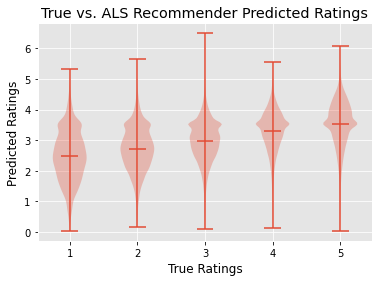

In [57]:

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

#### Additional Content

In [58]:
def rank_score(df):
    df2 = df.copy()
    df2['rank'] = df2.groupby("userId")["prediction"].rank("dense", ascending=False, na_option='top') -1
    df2 = df2.join(df2.groupby("userId")["rank"].max(), on='userId', rsuffix='_max')
    df2['pct_rank'] = df2['rank']/df2['rank_max']
    
    return np.sum(df2['interactions']*df2['pct_rank'])/np.sum(df2['interactions'])
    

In [59]:
implicit_predictions = recommender_imp.transform(test)

In [60]:
implicit_predictions_df = implicit_predictions.toPandas()

In [61]:
implicit_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200075 entries, 0 to 200074
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   budget                200075 non-null  float64
 1   popularity            200075 non-null  float64
 2   vote_average          200075 non-null  float64
 3   vote_count            200075 non-null  int64  
 4   startYear             200075 non-null  int64  
 5   runtimeMinutes        200075 non-null  float64
 6   averageRating         200075 non-null  float64
 7   numVotes              200075 non-null  int64  
 8   gnr_Action            200075 non-null  int64  
 9   gnr_Adventure         200075 non-null  int64  
 10  gnr_Comedy            200075 non-null  int64  
 11  gnr_Documentary       200075 non-null  int64  
 12  gnr_Drama             200075 non-null  int64  
 13  gnr_Horror            200075 non-null  int64  
 14  gnr_Sci-Fi            200075 non-null  int64  
 15  

In [62]:
implicit_predictions_df = implicit_predictions_df.fillna(0)

In [63]:
implicit_predictions_df

,budget,popularity,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adventure,gnr_Comedy,gnr_Documentary,gnr_Drama,gnr_Horror,gnr_Sci-Fi,gnr_Thriller,original_language_en,original_language_hi,original_language_it,original_language_ja,userId,movieId,rating,timeyear,prediction
0,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,132310,148,3.0,1996,0.000068
1,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,48928,148,2.0,2000,0.000890
2,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,107249,148,4.0,2001,0.000569
3,25000000.0,10.682,3.55,697,1994,111.0,3.60,77498,0,0,1,0,1,0,0,0,1,0,0,0,62935,471,4.0,2004,0.064007
4,25000000.0,10.682,3.55,697,1994,111.0,3.60,77498,0,0,1,0,1,0,0,0,1,0,0,0,112101,471,2.0,1999,0.091716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200070,35000000.0,13.851,3.55,1986,2015,123.0,3.60,88268,0,0,0,0,1,0,0,0,1,0,0,0,98931,145839,5.0,2019,0.002551
200071,22000000.0,17.941,3.15,1642,2015,101.0,3.20,57096,0,0,0,0,1,0,0,0,1,0,0,0,115907,146688,2.5,2016,0.000739
200072,24000000.0,13.542,3.70,470,2017,136.0,3.60,16210,0,0,0,0,1,0,0,0,1,0,0,0,19718,172667,4.0,2017,0.000273
200073,22000000.0,0.685,3.35,10,1958,66.0,3.45,531,0,0,0,0,1,0,0,0,0,0,0,0,72315,173465,3.5,2017,0.000000


In [64]:
# Rename column 'rating' to 'interactions' as that is what we are looking for.
implicit_predictions_df.rename(columns={'rating':'interactions'}, inplace=True)

In [65]:
implicit_predictions_df

,budget,popularity,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adventure,gnr_Comedy,gnr_Documentary,gnr_Drama,gnr_Horror,gnr_Sci-Fi,gnr_Thriller,original_language_en,original_language_hi,original_language_it,original_language_ja,userId,movieId,interactions,timeyear,prediction
0,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,132310,148,3.0,1996,0.000068
1,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,48928,148,2.0,2000,0.000890
2,4000000.0,6.213,3.50,29,1995,112.0,3.00,2626,0,0,1,0,1,0,0,0,1,0,0,0,107249,148,4.0,2001,0.000569
3,25000000.0,10.682,3.55,697,1994,111.0,3.60,77498,0,0,1,0,1,0,0,0,1,0,0,0,62935,471,4.0,2004,0.064007
4,25000000.0,10.682,3.55,697,1994,111.0,3.60,77498,0,0,1,0,1,0,0,0,1,0,0,0,112101,471,2.0,1999,0.091716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200070,35000000.0,13.851,3.55,1986,2015,123.0,3.60,88268,0,0,0,0,1,0,0,0,1,0,0,0,98931,145839,5.0,2019,0.002551
200071,22000000.0,17.941,3.15,1642,2015,101.0,3.20,57096,0,0,0,0,1,0,0,0,1,0,0,0,115907,146688,2.5,2016,0.000739
200072,24000000.0,13.542,3.70,470,2017,136.0,3.60,16210,0,0,0,0,1,0,0,0,1,0,0,0,19718,172667,4.0,2017,0.000273
200073,22000000.0,0.685,3.35,10,1958,66.0,3.45,531,0,0,0,0,1,0,0,0,0,0,0,0,72315,173465,3.5,2017,0.000000


In [66]:
rank_score(implicit_predictions_df)

0.3810871592080551

# User Account Management
## Main Function Objects
### Data written to file
#### The user record
This data is to be initialized by the user, with a minimum of a single item's key values. This creates a record to be saved to file. This record will be loaded in every time the user "signs in", which means loads their saved record. This record is instantiated into the class, where its methods enable adding/deleting items, and using the recommender to find more items.
#### Record Item Searching and declaration
Using a variety of searching (some based on regex), the user can locate items to add to their profile. At minimum is searching via title, but the more methods available the better. The user should be able to search by genre, name, and potentially weighted tags. This is to be created on availability of time. MVP: title
#### Record completion and imputation
As the user finds items through searching, ensure all fields saved to the user are functional.
### Recommender
#### Recommendation Search
The recommender will be called upon the moment the user class executes the function method to load all its item data into the model. Thus the user will receive a prediction based on their total complete record.
#### Archiving the result
Present the user with the choice to save items which are recommended. These will be added to their profile, thus increasing their unique data.
# User Interface and Display
## Basic display linking
For the next part of the project, the user should have comfortable display. Movie title and summary information is minimum, but additional data can be used to show descriptions, tags, keywords, and movie poster art. Many of these fields are often found NULL in their source data, and as such error handling and data processing must be present to ensure the query returns all required UI items without breaking functionality. In case of constraint toggle a simple mode to ensure verbose content can be skipped.

# User Recommendation Methods, Requirements, and Status
## Blind user, no given choices
Give them what is most popular. This requires no model.
This was explored and confirmed.
## Blind user, selects a genre
Filter popular results by the genre. This requires no model.
This was explored and confirmed.
## Seeking user wanting to give genre mapping
Give the user the weights, use these weights to find their closest internal user. This requires weights and models.

## Seeking user with an account who gives a mapping to tilt results
Multiply their given weight maps with their recorded recommendation data in file, if any. This requires weights, an account, and ratings in the model.
## Collaborative recommendation
Multiply the user's collected tastes with other users in the pool, use these weights to find the closest similar user. This requires multiple sets of weights.


# User account storage
## Structure
User account ID, user weights. At the start their weights are default or what they give. After they rate movies their data will be built into the model, then their recommendation pipeline will change to prefer their selection. The user can use a genre map to influence their recommendations by a given weight should they explore a change in taste.

In [67]:
movie_df['numVotes'].min()

5

In [68]:
# This works well. Sorting by these columns in this order produces high ratings with current focus and high praise
movie_df.sort_values(['averageRating', 'popularity', 'numVotes', 'runtimeMinutes'], ascending=False)

,budget,popularity,revenue,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv,movieId
35286,22000000,6.652,91258000,2018,73.0,4.70,229,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,200016
290,25000000,51.265,28341469,1994,142.0,4.65,2376952,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,318
751,6000000,41.776,245066411,1972,175.0,4.60,1646397,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,858
36274,22000000,3.548,91258000,2017,48.0,4.60,459,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,204768
35647,87500,5.492,91258000,2018,120.0,4.55,2701,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,201731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29373,7000,6.614,91258000,2005,66.0,0.75,270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,170819
23895,500000,6.972,2800000,2014,79.0,0.70,15181,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,141994
25330,22000000,3.513,91258000,1972,96.0,0.70,1260,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,149402
15525,22000000,4.319,91258000,1992,71.0,0.65,1736,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,96030


In [69]:
ml_m_df[ml_m_df['movieId']==71444]

,movieId,title
13798,71444,Thirst (Pyaasa) (1957)


In [70]:
uvfr = list(merged_movie_r_df_sample.iloc[:,8:20].columns)

# User weight matching and querying
##### Goal:
match a new user's weights with their most compatible in-model user.
Problem:
the numpy operation has no way to report the index of the 2nd input, the transposed established user matrix.
Solution:
write a function to hold this information in some form.
Priority:
low. For the purpose of minimum viable product, this can be skipped until later.
See requirements contract for exactly what must be delivered first!

Voila breaks on the cell below. Likely because of one of the possible features within:
The function is assigning to a variable, printing, and asking for inputs. Rather than ask for inputs I can probably make a widget that takes in parameters and influences the output of an item somewhere.

In [71]:
# user_acc_162541 = set_user_weights(162541, uvfi=uvfr, s=100, ud=None, sdf=None, m='set')

In [174]:
def find_best_match(newusers, currentusers, cuei=12):
    currentusers = currentusers.copy()
    currentusers = currentusers.iloc[:,:cuei]
    nu_shape = newusers.shape
    cu_shape = currentusers.shape
    if nu_shape[1] != cu_shape[1]:
        return "Column ranges of parameter dataframes are not equal!"
    nu_ind = list(newusers.index)
    marr = np.dot(newusers, currentusers.iloc[:,:cuei].T)
    ndf = pd.DataFrame(columns=['ClosestCurrentUser'])
    
    for newUser in range(nu_shape[0]):
        cu_ind = list(currentusers.index)
        ndl = list()
        highest_value = 0
        highest_user = None
        for currentUser in range(cu_shape[0]):
            current_value = marr[newUser,currentUser]
            if current_value > highest_value:
                highest_value = current_value
                highest_user = cu_ind[0]
            cu_ind.pop(0)
        ndl.append(highest_user)
        ndf.loc[nu_ind[0]] = ndl
        nu_ind.pop(0)
    return ndf

In [152]:
# find_best_match(user_acc_162541, uwdf, cuei=12)

# Dashboard Contents to Deploy
## Top Movies with Filter
## Genre Weight Sliders with Recommendation

Sidebar

In [188]:
genre_cols = ['Any']
genre_cols.extend(list(movie_df.columns[7:-1]))

In [189]:
axis_map = {
    "Average Rating": "averageRating",
    "Popularity": "popularity",
    "Number of Reviews": "numVotes",
    "Revenue Earned (dollars)": "revenue",
    "Length (minutes)": "runtimeMinutes",
    "Year": "startYear",
}

In [149]:
#genre_cols

# Filter Parameters

In [190]:
components = []

ratingc_label = widgets.HTML(value="Minimum number of ratings on IMDb:")
ratingc = widgets.IntSlider(value=100, min=100, max=3000000, step=100)
components.extend([ratingc_label, ratingc])

ratingv_label = widgets.HTML(value="Minimum average rating on IMDb:")
ratingv = widgets.IntSlider(value=0, min=0, max=5, step=1)
components.extend([ratingv_label, ratingv])

released_year_label = widgets.HTML(value="Year released:")
released_year = widgets.IntRangeSlider(value=[1911, 2021], min=1911, max=2021, step=1)
components.extend([released_year_label, released_year])

revenue_label = widgets.HTML(value="Revenue Earned:")
revenue = widgets.IntSlider(value=0, min=10000, max=300000000, step=10000)
components.extend([revenue_label, revenue])

genre_label = widgets.HTML(value="Genre (a movie can have multiple genres):")
genre = widgets.Dropdown(options=genre_cols, value="Any")
components.extend([genre_label, genre])

all_widgets = widgets.VBox(components)
all_widgets

# Variables

In [191]:
components = []

x_axis_label = widgets.HTML(value="X-axis variable:")
x_axis = widgets.Dropdown(options=list(axis_map.items()), value="runtimeMinutes")
components.extend([x_axis_label, x_axis])

y_axis_label = widgets.HTML(value="Y-axis variable:")
y_axis = widgets.Dropdown(options=list(axis_map.items()), value="averageRating")
components.extend([y_axis_label, y_axis])


note = "Note: The Average Rating is collected from IMDb, and is the average of 1 to 10 ratings given by users, divided by 2."
note_label = widgets.HTML(value=note)
components.append(note_label)

all_widgets = widgets.VBox(components)
all_widgets

In [192]:
movie_dfc = movie_df.copy()

In [205]:
movie_dfc = movie_dfc.merge(ml_m_df, how='inner', on='movieId')

In [214]:
#movie_dfc.to_csv('data/movie_dfce.zip')

In [193]:
movie_dfc["color"] = np.where(movie_dfc["averageRating"] > 3, "orange", "grey")
movie_dfc["alpha"] = np.where(movie_dfc["averageRating"] > 3, 0.9, 0.25)
movie_dfc.fillna(0, inplace=True)  # just replace missing values with zero
#movie_dfc["revenue"] = movie_dfc.revenue.apply(lambda x: '{:,d}'.format(int(x)))

In [124]:
#type(movie_dfc['revenue'][0])

In [108]:
#'{:,d}'.format(int(30))

In [194]:
fig = go.FigureWidget()
plot = go.Scatter(x=[], y=[], mode="markers", text=[], hoverinfo="text", marker=dict(color=[], opacity=[], size=7))
fig.add_trace(plot)

margin = go.layout.Margin(l=20, r=20, b=20, t=30)
fig = fig.update_layout(margin=margin)

In [213]:
def select_movies():
    selected = movie_dfc[
        (movie_dfc.numVotes >= ratingc.value) &
        (movie_dfc.averageRating >= ratingv.value) &
        (movie_dfc.revenue >= (revenue.value)) &
        (movie_dfc.startYear >= released_year.value[0]) &
        (movie_dfc.startYear <= released_year.value[1])
    ]
    if (genre.value == "Any"):
        return selected
    else:
        curgen = genre.value
        selected = selected[selected[curgen]>0]
        return selected


def on_value_change(change):
    movie_dfc = select_movies()
    x_name = x_axis.value
    y_name = y_axis.value

    fig.data[0]['x'] = movie_dfc[x_name]
    fig.data[0]['y'] = movie_dfc[y_name]
    fig.data[0]['marker']['color'] = movie_dfc["color"]
    fig.data[0]['marker']['opacity'] = movie_dfc["alpha"]
    fig.data[0]['text'] = movie_dfc["title"].astype(str) + "<br>" + movie_dfc["averageRating"].astype(str) + "<br>" + movie_dfc["numVotes"].astype(str) + "<br>"+ movie_dfc["revenue"].astype(str)
    
    fig.update_xaxes(title_text=x_axis.label)
    fig.update_yaxes(title_text=y_axis.label)
    fig.update_layout(title="%d movies selected" % len(movie_dfc))

In [196]:
controls = [ratingc, ratingv, released_year, revenue, genre]
for control in controls:
    control.observe(on_value_change, names="value")

In [212]:
on_value_change(None)
fig

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array(['orange', 'orange',…